In [13]:
!pip install pyDOE

In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [31]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.2, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x,0.5,0.05).T

#collocation points for every position and every time
X, T = np.meshgrid(x,t)


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [32]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [33]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=10 
        sigma2=0.25

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Solution Plot*

In [6]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.1s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.15s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [7]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
#solutionplot(u_pred,X_u_train,u_train)

0.48515057828334129 0.23644632642940888 0.24870425185393238 1.3042128554171049
0.42542609201068649 0.235957432506571 0.18946865950411551 1.2598258627702785
0.25671532781257622 0.23406870537381871 0.02264662243875749 1.0162166985083787
0.25502781715275114 0.23413228786657109 0.02089552928618002 1.0278772872031556
0.25405018177880351 0.23410146489185354 0.019948716886949942 1.0247595530155047
0.249103531752214 0.234104677636017 0.01499885411619699 1.0132922982974124
0.24217171627005457 0.23434096895530532 0.00783074731474924 1.0037752016644574
0.23755723853410557 0.2346843534264888 0.0028728851076167562 1.0023550639182306
0.23707929009728693 0.23466597708550066 0.0024133130117862697 1.0012354543468955
0.23702290936775466 0.23466570592122768 0.0023572034465269872 1.0010637484584273
0.23696888305774888 0.23467632913472897 0.0022925539230199028 1.000903038768828
0.23690085915966352 0.23469122304943546 0.002209636110228065 1.0007899885068392
0.23677584638436522 0.23471114568536683 0.00206470

0.23463733385008087 0.23458290319221409 5.4430657866796004e-05 1.0150778354832166
0.23463714407251993 0.23458071102499628 5.6433047523650122e-05 1.015090209276017
0.23463703055739002 0.23457982010989095 5.72104474990575e-05 1.0150707739444027
0.23463692860568131 0.23457945124917573 5.7477356505578373e-05 1.0150387270425252
0.23463685108460808 0.23457973723708625 5.7113847521841322e-05 1.0149453014389649
0.2346367877078839 0.23458024094850582 5.6546759378070059e-05 1.0147635816086666
0.23463674081941907 0.23458067087760553 5.6069941813548727e-05 1.0145370731893701
0.23463670144203727 0.23458078818747222 5.5913254565059223e-05 1.014369691268331
0.2346366581552464 0.23458087921494911 5.5778940297278849e-05 1.0141729146161331
0.23463661768128413 0.23458087882279188 5.5738858492247771e-05 1.0140362936685463
0.23463654530120828 0.23458103571217137 5.5509589036914141e-05 1.0138539277293444
0.23463644944012435 0.2345807802174002 5.5669222724155781e-05 1.0137294721152423
0.23463633376230997 0.2

0.23460785815828586 0.2345503826412105 5.7475517075342688e-05 1.0234441961350231
0.23460770444687529 0.23455010920409516 5.7595242780113592e-05 1.0233043106616277
0.23460753365011905 0.23455295074853613 5.4582901582914513e-05 1.0230436483370362
0.23460728776331036 0.23455160644293527 5.5681320375092216e-05 1.0232505153038312
0.2346071945263849 0.23455083271336916 5.63618130157523e-05 1.0233073256010532
0.23460706324512878 0.2345510752494154 5.5987995713387011e-05 1.0239381048239438
0.23460688218221915 0.23454958976444967 5.7292417769464449e-05 1.0236616247046015
0.23460675152389621 0.23455165486543014 5.5096658466073864e-05 1.0236998217293114
0.23460664824577726 0.23455194290122633 5.4705344550923192e-05 1.023525566795719
0.23460661323226345 0.23455063668924683 5.5976543016623563e-05 1.0235048692714743
0.2346064744650683 0.23455032291496325 5.6151550105059146e-05 1.0234566448336957
0.234606395614163 0.23455110082778349 5.5294786379497804e-05 1.0236639841993593
0.23460630638262364 0.234

0.23460235849648675 0.234552527552297 4.9830944189752163e-05 1.0267748083237112
0.23460234966523916 0.23455184585943623 5.050380580293653e-05 1.0267446850971833
0.23460234263526566 0.23455166856546678 5.0674069798895819e-05 1.026736539692441
0.23460231319697025 0.23455037832619527 5.1934870774995215e-05 1.0267077721488596
0.23460228066100364 0.23455120026597873 5.1080395024917147e-05 1.026772246737081
0.23460226340301635 0.23455169990277308 5.0563500243257418e-05 1.0268304147757232
0.23460223032469124 0.23455118245670548 5.1047867985778753e-05 1.0269019523548726
0.23460219828880413 0.23455023942512562 5.1958863678496566e-05 1.0269683509287115
0.23460217506952274 0.23455087318443077 5.13018850919657e-05 1.0271205586828962
0.23460210302136913 0.234549572613377 5.2530407992133215e-05 1.0270894921912557
0.23460203134802005 0.23454980953160878 5.2221816411275363e-05 1.0270449405856237
0.23460190225257413 0.23455039685438797 5.1505398186147644e-05 1.0271548960732484
0.23460180048150817 0.234

0.23459174609392835 0.23453421885476275 5.7527239165612248e-05 1.0303275328614587
0.23459170360994142 0.23453397780112839 5.7725808813020987e-05 1.030284102948093
0.23459167853125268 0.23453343152855285 5.8247002699826704e-05 1.0302450452623213
0.23459166602540396 0.23453242234855018 5.9243676853780552e-05 1.0302767735640888
0.234591660314412 0.23453211143875041 5.9548875661585187e-05 1.0303661306542478
0.23459165705657117 0.23453226853057385 5.9388525997311362e-05 1.0303509096798649
0.23459165248468689 0.23453215279487857 5.9499689808325295e-05 1.030410151151172
0.23459163223681329 0.23453180765404871 5.9824582764572508e-05 1.0305517010366128
0.23459158925949009 0.23453117375642107 6.041550306901989e-05 1.0306404157160964
0.23459154079785868 0.23453090962722506 6.0631170633626257e-05 1.0304559300429426
0.23459148834066657 0.23453166429153735 5.9824049129218531e-05 1.0298750682950466
0.2345914758580471 0.23453171330879286 5.9762549254257874e-05 1.029797714210712
0.23459145657432359 0.2

0.23458192617101725 0.23452575080781884 5.6175363198420073e-05 1.0331649211757379
0.23458172782914122 0.23452737772468638 5.435010445484637e-05 1.0325097412150097
0.23458168491215342 0.23452769399387907 5.3990918274335907e-05 1.032395220444253
0.23458155996149938 0.23452792288357585 5.3637077923529122e-05 1.0318593443788175
0.23458152067309507 0.23452373419067352 5.778648242154718e-05 1.03141679505021
0.23458123007131781 0.23452698033098848 5.424974032934127e-05 1.0321922770758307
0.23458107976922096 0.23452508738602632 5.5992383194655493e-05 1.0329638948242292
0.23458086985896134 0.23452369149415844 5.7178364802900033e-05 1.0336748406335214
0.23458072424248533 0.23452376982651552 5.695441596980798e-05 1.0335014628307857
0.23458055197625349 0.23452024389727372 6.0308078979782681e-05 1.0332921045154526
0.23458046773565139 0.23451803134908614 6.243638656523796e-05 1.0330896639043576
0.23458035351831674 0.23451797366953692 6.2379848779833182e-05 1.033328941822463
0.23458032376256879 0.234

0.23456951271376075 0.23449485000348222 7.4662710278524389e-05 1.0377730781393926
0.23456913214043654 0.23449452287796621 7.46092624703376e-05 1.0379402410023286
0.23456881482784867 0.23449230938497675 7.6505442871901668e-05 1.0385312600705725
0.23456855315180228 0.23449318927116461 7.5363880637680024e-05 1.0385801467913025
0.23456834095539103 0.23448612091339427 8.2220041996768864e-05 1.039348891794249
0.23456813061340348 0.23448835181375224 7.9778799651246377e-05 1.039437625627233
0.2345680050766987 0.23448949485568868 7.8510221010007135e-05 1.0395753355720811
0.23456795942811984 0.23448921370231793 7.8745725801910956e-05 1.039597203696055
0.23456788907063394 0.2344887610312365 7.91280393974534e-05 1.0396498027395726
0.2345677834947619 0.23448834605342969 7.9437441332221736e-05 1.0396248116012015
0.23456769282544435 0.2344874765458404 8.0216279603947e-05 1.039384006696856
0.23456762703148468 0.23448764963488686 7.9977396597831626e-05 1.0391884628197592
0.23456757121429084 0.234485799

0.23455388465355972 0.23447479923397085 7.9085419588877348e-05 1.041960146480861
0.23455371567594596 0.23447445911803341 7.9256557912560255e-05 1.0420648212730734
0.23455346928096113 0.2344747302053603 7.8739075600811818e-05 1.0418314284307177
0.23455308529204016 0.23447560093150094 7.748436053923984e-05 1.0409659726592941
0.23455282196165364 0.23447308492780067 7.973703385298438e-05 1.040669685722296
0.23455276136653438 0.2344781564900231 7.46048765112775e-05 1.03978988862571
0.23455228940518358 0.23447457573793815 7.7713667245427319e-05 1.0410113376150345
0.234551972319029 0.23447234946262249 7.9622856406505666e-05 1.0412462153450084
0.23455181070500858 0.23447076008022 8.1050624788569519e-05 1.0415005868447638
0.23455130399858498 0.234471497018829 7.9806979755990383e-05 1.0416285054142926
0.23455104164583399 0.23447323765397923 7.78039918547416e-05 1.04155402466983
0.23455052071620044 0.23447632725712378 7.41934590766582e-05 1.041383610372157
0.23455003302218685 0.23447344792038907 

0.2345307036170447 0.23444241437083166 8.8289246213040144e-05 1.0471456351910322
0.23453068385392645 0.23444204946069316 8.8634393233285485e-05 1.047128628602005
0.23453067633575297 0.23444180835796422 8.88679777887644e-05 1.0472019633305552
0.2345306686979077 0.2344413414654461 8.9327232461618389e-05 1.0472801059347714
0.23453066079540158 0.23444082371292713 8.9837082474448468e-05 1.0473430416752099
0.23453065124430028 0.23444019807787778 9.0453166422510155e-05 1.0474292826465836
0.23453064272772284 0.234439929960699 9.0712767023820037e-05 1.0474686810049743
0.23453063221700024 0.23443982202147168 9.0810195528565391e-05 1.0474914524301435
0.23453062053065526 0.23444042424994305 9.0196280712206655e-05 1.0474272548393715
0.23453060848570312 0.23444084494812051 8.97635375826134e-05 1.0473501579013662
0.23453058613177363 0.23444167006762973 8.8916064143917825e-05 1.047234425602569
0.23453055877260212 0.23444215897915771 8.8399793444416484e-05 1.0471953407506878
0.23453052536621805 0.23444

0.23451802350107087 0.23442515525944463 9.2868241626241008e-05 1.0534620699710757
0.23451793927081843 0.23442462474704137 9.33145237770591e-05 1.0531421777657821
0.23451788509894286 0.23442754792258119 9.03371763616575e-05 1.0534469513215399
0.23451772827869077 0.23442678358382657 9.0944694864213642e-05 1.0531676442091735
0.2345176800392676 0.23442509865724256 9.2581382025032078e-05 1.0532977525879548
0.23451759222844185 0.23442441165354966 9.3180574892174554e-05 1.053240763226272
0.23451740860297537 0.2344219781707382 9.5430432237162525e-05 1.0539388029760688
0.23451735934826604 0.23442161254750216 9.5746800763887789e-05 1.053791126282006
0.23451730241511362 0.23442232263218549 9.4979782928132468e-05 1.0535573692961464
0.23451723143072037 0.2344201710544884 9.7060376231980882e-05 1.0537714207851714
0.23451709221855158 0.2344217174549808 9.5374763570780333e-05 1.0539385821227174
0.23451702585321352 0.2344216398893107 9.5385963902826638e-05 1.0537363134152462
0.23451699958940331 0.23442

0.23449932952791661 0.2343972339287699 0.00010209559914670023 1.0621501741045665
0.23449910358042325 0.23439642069196645 0.00010268288845681402 1.0622187861258443
0.23449877712856459 0.23439666207319967 0.00010211505536491039 1.0622591126271146
0.23449854617514473 0.23439825620115839 0.00010028997398633568 1.0630849638058881
0.23449832093175718 0.23439004723471757 0.00010827369703961324 1.0650067982401876
0.23449808051691473 0.23439351209749393 0.00010456841942080523 1.0646192614925714
0.23449794579818287 0.23439208905819578 0.00010585673998709834 1.0647212830040524
0.23449769979637139 0.23438544524919716 0.00011225454717421918 1.066384677021746
0.23449752672176014 0.23438750043564627 0.00011002628611388006 1.0659262966294119
0.23449744068000508 0.23438687035350897 0.00011057032649612025 1.066522501005182
0.23449738391059544 0.23438500946086813 0.00011237444972729691 1.0676603139733267
0.23449730773538424 0.23438642740667356 0.00011088032871068436 1.066960824244021
0.23449724562622107 

0.23447051861980359 0.23437519494266984 9.5323677133746977e-05 1.0766492668681844
0.23446977170986694 0.23437578341808762 9.3988291779326037e-05 1.075330846008218
0.2344682573326741 0.23437770350115361 9.0553831520474e-05 1.075820946128691
0.23446765832140121 0.23437477300863774 9.28853127634814e-05 1.07804512584709
0.23446710370254006 0.23437547860458624 9.1625097953815433e-05 1.079322819642751
0.23446691926812965 0.23437553843116657 9.1380836963077047e-05 1.0793029195411457
0.23446683580323932 0.23438169999539685 8.513580784247151e-05 1.0775815441606535
0.23446645725094339 0.23437550001371285 9.0957237230545988e-05 1.0785615368280308
0.23446613797742408 0.23437677847627295 8.9359501151131711e-05 1.0799182648584358
0.2344657092063242 0.23437730111183042 8.8408094493798458e-05 1.0794095370109187
0.23446525037159902 0.23437411973489072 9.1130636708305142e-05 1.0793773432893323
0.2344648990502449 0.23437777430584547 8.7124744399417556e-05 1.0796868179806884
0.23446470998922037 0.23437488

0.23438460897876454 0.23427717412263957 0.0001074348561249531 1.1194154728818873
0.23438321137930748 0.23428017957945552 0.00010303179985196917 1.12166526605754
0.2343823400465985 0.23428001275591379 0.00010232729068472213 1.1259268283440536
0.23438150940575739 0.23428068641506272 0.00010082299069466957 1.1275956490353491
0.23438118135732935 0.2342784859970474 0.00010269536028195452 1.1289521464562369
0.23438101261356928 0.23428222814066466 9.8784472904620636e-05 1.1266752098140849
0.23438064644034615 0.23428155731021708 9.908913012905876e-05 1.127913865517446
0.23438046401382726 0.23427987258440214 0.00010059142942510551 1.1276239730408888
0.23438023358836022 0.23427872031507607 0.00010151327328414334 1.1273830819663708
0.2343799726334983 0.23427787553354229 0.0001020970999560047 1.125861236913475
0.23437976696417284 0.23427898590217461 0.00010078106199824067 1.1259197408102555
0.23437950511950123 0.23427671216593465 0.00010279295356656864 1.1256671660748672
0.23437932370002462 0.2342

0.23432466520817274 0.23422647761503207 9.8187593140688814e-05 1.141154699779215
0.23432400954274329 0.2342208924610398 0.00010311708170348563 1.1431859992480837
0.2343227173603914 0.23421906765865369 0.00010364970173770964 1.1443788330063307
0.23432150240752017 0.23421755754010712 0.00010394486741304442 1.146276179749419
0.23432061634725673 0.234220163608869 0.00010045273838774802 1.1454318744259593
0.23432000912081496 0.234222696986353 9.7312134461969316e-05 1.1482197067406652
0.23431982651564698 0.2342230646393807 9.6761876266291872e-05 1.1452320102124136
0.2343187081296513 0.23422877366629297 8.9934463358325541e-05 1.1422340145584193
0.23431845275683064 0.23422198657979082 9.6466177039822534e-05 1.1417752501753653
0.23431793780302765 0.23421678926031428 0.00010114854271336107 1.1445883946057507
0.23431743511646397 0.23422194749258488 9.54876238790961e-05 1.1435480601584191
0.23431682380284635 0.23422421741555349 9.2606387292848549e-05 1.1422269761419153
0.23431591827976292 0.234220

0.23423769498466238 0.23404188477897006 0.0001958102056923047 1.2051097772476118
0.23423675258641918 0.23404596181207868 0.00019079077434049253 1.202928521876534
0.23423355662698372 0.23404049046572045 0.00019306616126326388 1.2006749139552957
0.23423186645491625 0.23404118307622843 0.00019068337868782511 1.2000242179122376
0.23422991631137915 0.23403070016394575 0.00019921614743339757 1.201222314231653
0.23422885950177386 0.23403460168076978 0.00019425782100406587 1.202661976295448
0.23422739975551476 0.23402211902756254 0.00020528072795221686 1.2056604464025074
0.23422722792706271 0.23402716150832847 0.00020006641873425286 1.2062787686155443
0.23422622310865535 0.23402131046834285 0.00020491264031248906 1.2078937948391917
0.23422595749258959 0.23402146446349661 0.0002044930290929679 1.2100335530412667
0.23422557176404946 0.23401780350808266 0.00020776825596678891 1.211155523935094
0.23422475161770739 0.234015006087692 0.00020974553001540107 1.2133542443827725
0.23422346720166462 0.23

0.23373251046773458 0.23330983864637891 0.00042267182135567429 1.5687886807018856
0.23373025395453645 0.23331649349620476 0.00041376045833168781 1.5637115312008598
0.23372920036057385 0.23332555024318705 0.00040365011738679709 1.5581693249269017
0.23372806727493439 0.23333256839201019 0.00039549888292421322 1.5531546566570158
0.23372592654709837 0.2333410457843631 0.00038488076273526393 1.5468532566668545
0.23372213761841376 0.23334475923761483 0.00037737838079892185 1.5438993486734776
0.23371439505205416 0.23333154120188623 0.00038285385016792147 1.5497122344575418
0.23370684755607246 0.23329597244399278 0.00041087511207968353 1.5543695257133945
0.23369531406466332 0.23327254167020711 0.00042277239445619782 1.5616224693334146
0.23368032407618924 0.23322314020443957 0.00045718387174966681 1.5775427634531343
0.23365127861131479 0.23312226075748316 0.00052901785383163377 1.619927461243661
0.23362808824315828 0.23311718914493931 0.00051089909821898317 1.6202995467640602
0.2335967006563049

0.23306233537523777 0.23265977970856341 0.00040255566667435745 1.6964583210070565
0.23305268091127238 0.23262772327715178 0.00042495763412059187 1.7047140769334241
0.233048358387605 0.23260397828536014 0.00044438010224484467 1.7054757274860497
0.23304459336117597 0.23261642393308879 0.00042816942808717563 1.6995649628492548
0.23304231837891345 0.23261954268077434 0.00042277569813912194 1.7027523954777213
0.23303834110456062 0.23260723514929252 0.00043110595526810408 1.7025364754344896
0.23303499840025818 0.23259807665928725 0.00043692174097092573 1.703982323525628
0.23303131115790959 0.2325863125231554 0.0004449986347542053 1.7049938325539937
0.23302680219337549 0.23258118321528731 0.00044561897808818575 1.7055328169239368
0.23302485592119382 0.23257628782575279 0.00044856809544102579 1.706955714771161
0.23302198621345455 0.232581379347666 0.00044060686578854515 1.7093357756159506
0.23301865825999948 0.23258002780282708 0.00043863045717241605 1.708853742041976
0.2330133429220709 0.2325

0.23235417104666653 0.23121438443469952 0.0011397866119670205 2.286013445489629
0.2323474015015147 0.23120672799892161 0.0011406735025930759 2.281904911476841
0.23234189418655168 0.23116395882707522 0.0011779353594764705 2.291462550498486
0.23232444367663391 0.23118897697743934 0.0011354666991945598 2.2689121269164874
0.23230598910367037 0.231149580845596 0.0011564082580743586 2.283322262709595
0.23229062950638385 0.23113512847834619 0.0011555010280376499 2.2914524051682057
0.23227113558819215 0.23113445502444949 0.0011366805637426636 2.305595027254416
0.23226035386137373 0.23112013755984237 0.0011402163015313558 2.313881006827403
0.2322434294533619 0.23112127142355759 0.0011221580298043192 2.319015166279178
0.23223120100613742 0.23108039377534093 0.0011508072307964941 2.341267214290381
0.23221097491048956 0.23110070274458727 0.0011102721659022785 2.32535908691877
0.23219738856597186 0.2311307548061512 0.0010666337598206493 2.3409272394328138
0.23217389810401221 0.23111913458450142 0.0

0.23035105127998171 0.22777023951486869 0.0025808117651130113 3.2704955381659118
0.23033906061320103 0.22775159492492053 0.0025874656882804935 3.277616030477076
0.23030975290771538 0.22765745183693933 0.0026523010707760405 3.3201626327615616
0.23028950640125059 0.22755876942845529 0.002730736972795301 3.3620157273367006
0.23027543101136233 0.22752264237186889 0.0027527886394934347 3.3821181052975615
0.23026279665772817 0.227481163177235 0.0027816334804931756 3.3978525809382916
0.23024927507746579 0.22752071556451506 0.0027285595129507402 3.387745056642407
0.23024010523915889 0.22751684624203403 0.0027232589971248737 3.3960290189568036
0.230230118468197 0.22754516455703017 0.0026849539111668146 3.3851564874300273
0.23021228714539987 0.22754187697420913 0.0026704101711907432 3.3871048911824464
0.23018700775551357 0.22753196279972776 0.0026550449557858039 3.392745035920634
0.23016588773505423 0.22750501510967849 0.0026608726253757194 3.3982741075248186
0.23014095661564105 0.22746386891210

0.20923851422992679 0.19777476484508011 0.011463749384846667 7.545123823207426
0.20894683485553373 0.19775558877987573 0.01119124607565799 7.566756965823377
0.20860171764725766 0.19688026281279192 0.011721454834465728 7.576871755563235
0.20806043137108585 0.1960194842621763 0.012040947108909537 7.606080642360714
0.20794595672320706 0.19470036951342379 0.013245587209783281 7.670973276152991
0.20720065431703075 0.19219611471648085 0.015004539600549911 7.864929709597173
0.20675381338872703 0.19292246373252378 0.013831349656203253 7.817373700864139
0.20635485457128816 0.19335079521185142 0.013004059359436729 7.694936410270039
0.20579197527990226 0.19241085525195389 0.013381120027948354 7.8152361733796205
0.20424742597219489 0.18901435285461876 0.015233073117576122 8.00882312413883
0.20318984420939634 0.18750218215902742 0.015687662050368926 8.010974701726482
0.20274839092922464 0.18797429894175152 0.014774091987473106 7.839993225245401
0.20252017773152417 0.18728154246556653 0.015238635265

0.13563873084146388 0.1170736161300226 0.018565114711441285 12.31893351839573
0.13537288863621916 0.11698738417384316 0.018385504462375992 12.330839524377298
0.13517598370804068 0.1170055277915283 0.018170455916512378 12.324691284690925
0.13498943695573648 0.11703580231009764 0.017953634645638841 12.31160980296628
0.13473722175493336 0.11749952247627393 0.01723769927865941 12.26108149241729
0.13441698438141225 0.1173419310921016 0.017075053289310638 12.284834112360839
0.13400246446116629 0.11704755507853216 0.016954909382634126 12.328445126310477
0.13359221957073508 0.11654180937744356 0.017050410193291534 12.391207709603188
0.133154971281799 0.1158939474490628 0.017261023832736224 12.476009864453104
0.13269951476744124 0.11514323292553937 0.017556281841901888 12.563362992552626
0.13241003578452115 0.11479623115477786 0.017613804629743303 12.597964635455341
0.13225186144624787 0.11491331292804668 0.017338548518201196 12.575912472194831
0.13180439657651039 0.11492695828498341 0.01687743

0.086491822070155114 0.074152925760285218 0.0123388963098699 20.255173652543036
0.086429026952907953 0.07374680823029435 0.012682218722613606 20.31928184922027
0.086234494846823523 0.074045559167951649 0.012188935678871866 20.272929517331896
0.08616483506271598 0.073855510463302187 0.012309324599413791 20.35492520153317
0.086030913635810363 0.073775174280617847 0.012255739355192521 20.359021472654945
0.0857402165853742 0.07373664096681555 0.012003575618558653 20.318859323474303
0.085382449895697515 0.07357442601809025 0.011808023877607262 20.28545692022089
0.0849963304929979 0.073514909048294552 0.011481421444703354 20.28154728957491
0.084566751482541933 0.07385031182525538 0.010716439657286551 20.142569064019536
0.084210720620244428 0.073816023979674683 0.01039469664056975 20.14584234366078
0.083659807421260377 0.07349916819848927 0.010160639222771108 20.26332546527326
0.083318083319395456 0.073369301542451276 0.0099487817769441777 20.33346653444923
0.083061468185376186 0.073270360744

0.063929191434969238 0.058240339170279237 0.0056888522646899994 23.77213075208553
0.06374938065521453 0.058066513035558875 0.0056828676196556526 23.849303869282345
0.063608834978061149 0.057664685344348911 0.0059441496337122391 23.999789723854363
0.063471708905381632 0.057544741766447464 0.0059269671389341637 24.067880038667134
0.063413495063004588 0.057488335879660374 0.0059251591833442176 24.0912184190348
0.063391655052649418 0.057638750899096376 0.0057529041535530423 24.00165833174482
0.063273296836577952 0.057480447910426578 0.0057928489261513732 24.07579963945133
0.06320121320968744 0.057334322127220935 0.0058668910824665093 24.15447589703969
0.0631276067657808 0.057143126359634616 0.0059844804061461926 24.256097153166184
0.0630232062297655 0.057190187710627921 0.0058330185191375755 24.227141456631724
0.0629964740186146 0.057334055329097945 0.0056624186895166666 24.16067460116277
0.062953891629880229 0.057201067721052927 0.0057528239088273005 24.217936783068303
0.06291390682117607

0.056468192995702875 0.051515277568472351 0.0049529154272305248 24.766559557823296
0.056456020228179957 0.051431839126852723 0.0050241811013272365 24.854581837526368
0.0564257333121663 0.051339924181465137 0.0050858091307011593 24.87273279522317
0.056384798555575738 0.0514053555279638 0.004979443027611938 24.851081792026175
0.056347331233815787 0.051398021399141784 0.0049493098346740007 24.894764464631564
0.056285735643469642 0.05126208355074522 0.0050236520927244236 24.987484616807293
0.056199787241430696 0.051162137934572194 0.0050376493068585038 25.060480929176435
0.056118344906361056 0.050917992413965808 0.0052003524923952453 25.231977730762516
0.0560840210517268 0.050967404230806465 0.0051166168209203326 25.257237761445637
0.05603354364991904 0.050868143204213574 0.00516540044570547 25.234276874323633
0.055956048210877733 0.050800686301729334 0.005155361909148397 25.24235258383523
0.055856544671817741 0.050683224985026185 0.0051733196867915542 25.25665294064606
0.05578022300975325

0.051354373614040071 0.046801528797538759 0.0045528448165013087 25.900976677217106
0.051317492105071826 0.04677125748229647 0.0045462346227753544 25.89047540934069
0.051307100272483121 0.046675399499829212 0.0046317007726539077 25.89192882149701
0.051259248436049731 0.046612602283011312 0.0046466461530384221 25.88352787540524
0.05123707146594831 0.046590137138309486 0.0046469343276388259 25.89931726772453
0.051216930376105939 0.046538735879679542 0.0046781944964263975 25.91051563860114
0.051191833501933341 0.046427373308299567 0.0047644601936337721 25.92033551846093
0.051172847886906535 0.046400850739411449 0.0047719971474950856 25.921819773443506
0.051136881190367932 0.046375600187340875 0.0047612810030270569 25.910631997675484
0.051106568626685875 0.046392405603433613 0.0047141630232522651 25.873419572848935
0.051096792496057572 0.046490816436775356 0.0046059760592822123 25.845906529460798
0.051048935216925849 0.046425820522891806 0.0046231146940340423 25.810120883922956
0.0510203510

0.048915574249434192 0.044372545919461132 0.0045430283299730612 26.173521488049307
0.048884071028416229 0.044280896268825309 0.004603174759590916 26.11679075082701
0.048860849689561489 0.044234992666635171 0.0046258570229263168 26.14496885685779
0.048841712084618238 0.044118609776453883 0.0047231023081643559 26.121830831160278
0.048809148257578587 0.043912118333530356 0.0048970299240482327 26.01920065812643
0.048751867127182505 0.043950919376358165 0.0048009477508243366 25.97646631660011
0.0487037703414823 0.0437898603118874 0.0049139100295949008 25.956598174639296
0.04864312999283886 0.043640547240221747 0.0050025827526171095 25.892636802152953
0.04860864137468119 0.04351951436064893 0.0050891270140322577 25.82725910966096
0.04858962227103017 0.04344288233081512 0.0051467399402150508 25.800290176107872
0.048561705403174935 0.043414624836871377 0.0051470805663035614 25.813147181400026
0.048530925845187339 0.043254870773182866 0.0052760550720044753 25.779612379104236
0.04850716509282317

0.043418113837524724 0.038907779689961786 0.0045103341475629354 25.180761952150604
0.043380008451954076 0.038872702250391078 0.0045073062015629954 25.109331351602716
0.043337273820663859 0.038839107436164 0.004498166384499863 25.08188180797598
0.043306130805391918 0.038792659605561296 0.0045134711998306223 25.06416715150352
0.043282512836041349 0.038802761381383395 0.0044797514546579516 25.06117097583604
0.043252864872296633 0.0387539141184767 0.00449895075381993 25.099063008357973
0.043223453314279153 0.038719690396127313 0.0045037629181518381 25.12799407167476
0.043188066543896314 0.03868209514103129 0.0045059714028650253 25.185837164588136
0.043152693218869477 0.03857590098842803 0.0045767922304414486 25.21850778193003
0.043146653130846084 0.0385512319339267 0.004595421196919385 25.2620119251858
0.043126630265635353 0.03848186727256591 0.00464476299306944 25.23787526515756
0.0431187464227513 0.038468039174211932 0.0046507072485393649 25.227246097516183
0.043105867017108342 0.0384289

0.040241358683588704 0.034388610380864951 0.00585274830272375 26.04257978562921
0.040221650897683668 0.03436033658973392 0.0058613143079497458 26.068776608687077
0.040181773501402868 0.034339160985109134 0.0058426125162937357 26.138934874588646
0.040144675690883036 0.0343063863885794 0.005838289302303637 26.24501284885568
0.040128259425484217 0.034355922680749044 0.0057723367447351723 26.34518736871027
0.040095034329962705 0.034345859389535972 0.0057491749404267323 26.38606908994157
0.040078240832564192 0.034355195180182638 0.0057230456523815563 26.351826923605735
0.040054818418467 0.03436476432430062 0.0056900540941663847 26.34036616894927
0.040032782752395829 0.034365924565335493 0.0056668581870603345 26.32553671497425
0.040023611238275511 0.034390563116934947 0.0056330481213405616 26.345984443975446
0.040010448579318861 0.034369895424833936 0.005640553154484927 26.348617630328054
0.039994228434038326 0.034404489481832876 0.0055897389522054494 26.368621168851618
0.039976645311378387 

0.036750060613996549 0.031213806528341437 0.0055362540856551123 24.8400880792865
0.036711969642069062 0.031196365279353582 0.0055156043627154821 24.833646171946686
0.036654843771668076 0.031166725125862504 0.00548811864580557 24.88684184823455
0.036597066680303242 0.031116651942460938 0.0054804147378423006 24.94224123406625
0.036533704212801651 0.031042011188835813 0.0054916930239658369 25.048215905101863
0.036448400761103804 0.030989219650205797 0.0054591811108980074 25.0363758476934
0.036383525797015051 0.030936285636242761 0.0054472401607722886 25.032071239425022
0.036333068920148814 0.030772074682402204 0.0055609942377466111 25.03061423499061
0.036232294100995488 0.030717462603954155 0.00551483149704133 25.078880044048123
0.036176922762197243 0.030526243096251411 0.0056506796659458319 25.081924577902146
0.036142365190254856 0.030551603299944358 0.0055907618903104986 25.144504070684757
0.036105165492926805 0.030536414716568656 0.00556875077635815 25.109034001814816
0.036052510196241

0.03341469373559728 0.028533440840045863 0.0048812528955514195 25.36337363046412
0.033396337217996265 0.028523482019222 0.0048728551987742667 25.3100551392081
0.033379688751142056 0.028505380230236667 0.00487430852090539 25.280042354411464
0.033354150153166104 0.028488730219053654 0.0048654199341124464 25.22586136193837
0.03332504871826824 0.028457361531718506 0.00486768718654973 25.240790298986024
0.033295031989104176 0.02837120960211393 0.0049238223869902484 25.286792798437627
0.033271914580069686 0.028293788295709929 0.0049781262843597539 25.340874175065036
0.033255254579220614 0.028261123973381628 0.004994130605838986 25.388412292767526
0.033246614353497635 0.0282311951268855 0.005015419226612138 25.38955634294521
0.033232102619353741 0.028233008957831589 0.0049990936615221544 25.411991269034047
0.033223563408719625 0.028232758806562532 0.0049908046021570956 25.41531910341311
0.033210622185317062 0.028193027407485468 0.0050175947778315954 25.419313831901192
0.033200938417893219 0.0

0.029073766111084448 0.023357836191575585 0.0057159299195088621 26.171925333858084
0.029044620747432061 0.023314773217540562 0.0057298475298914985 26.203842685996403
0.02899701080454288 0.023336103021795743 0.0056609077827471359 26.185603482282342
0.028958502174199239 0.023294981574418224 0.0056635205997810148 26.21218862930493
0.0289327016733365 0.023285608664661041 0.0056470930086754577 26.23818398195666
0.028916754518595107 0.023293032466337991 0.0056237220522571147 26.278198439050126
0.028894926545461608 0.023313504598625242 0.0055814219468363676 26.32983276836963
0.028858801354802632 0.0233625682755162 0.00549623307928643 26.377778567339192
0.028796563775647387 0.023418873269977682 0.0053776905056697058 26.389338728067493
0.028745019499402495 0.02347307161190627 0.0052719478874962266 26.39381577138119
0.028673808354619648 0.02348274220837461 0.0051910661462450363 26.302027084540175
0.028597641151053371 0.023340854053835951 0.0052567870972174214 26.213030019824753
0.028569895524361

0.02562084473168744 0.020469788939067684 0.0051510557926197553 24.706646178112635
0.025598271160844933 0.020401932627011132 0.0051963385338338 24.721571762148496
0.025566301138197814 0.020277138565333388 0.0052891625728644269 24.77319855804414
0.025541104558060357 0.020161523489148365 0.00537958106891199 24.83258679994242
0.02551034570807546 0.020032158195865259 0.0054781875122102012 24.925819276918915
0.025477571448109908 0.019994279360564859 0.0054832920875450492 25.00065782652619
0.025461567265093056 0.020034220525062565 0.00542734674003049 25.035794206515185
0.0254475954677729 0.020028633696137336 0.0054189617716355627 25.008257597190838
0.025439068490697114 0.020060693799761067 0.0053783746909360471 24.994872346027442
0.025422255239917826 0.02001190449197068 0.0054103507479471473 25.003344409738585
0.025398862233399919 0.020005186244920987 0.0053936759884789321 24.98900570864304
0.025368540999385004 0.019963834550925642 0.0054047064484593621 24.967518940399298
0.025332758460646528

0.022842162330500692 0.017763462547922042 0.0050786997825786511 24.956061599839266
0.022832726803775152 0.017768469328228089 0.0050642574755470626 24.974690859302655
0.022823754655087972 0.017764509721563803 0.0050592449335241678 24.977162376659383
0.022816227809666918 0.017734141951589552 0.0050820858580773679 24.98994067361536
0.02280800000682242 0.017721944289222344 0.0050860557176000765 24.980637422690798
0.022796730212484441 0.017657974855767904 0.0051387553567165383 24.954163173362666
0.022787990348999487 0.01758914481845204 0.0051988455305474477 24.9567460119718
0.02277400942586812 0.017548196003774656 0.0052258134220934645 24.933015416015696
0.022744518078568979 0.017449319178895611 0.0052951988996733671 24.918933262718152
0.022723264199489585 0.017383781830562162 0.005339482368927422 24.897903389132626
0.022699666764369089 0.017299828225473855 0.0053998385388952363 24.883773935555936
0.022681205380726786 0.017286919005040924 0.0053942863756858616 24.85438272624067
0.0226521634

0.020201262517646687 0.01463419812516931 0.005567064392477377 24.0879733360767
0.020139914553696483 0.014583795214659939 0.0055561193390365428 24.139404465861737
0.020106529710462947 0.014451468478186317 0.0056550612322766288 24.12950238170963
0.020060571820291924 0.014364945195992825 0.005695626624299099 24.149395519449136
0.019987362679717426 0.014317836031844758 0.0056695266478726672 24.193409987076304
0.019893094217697135 0.01422861759615392 0.0056644766215432135 24.253076634081967
0.019813848517317465 0.014268292029436833 0.0055455564878806327 24.25562279686662
0.019766797309140608 0.014294618576477651 0.0054721787326629566 24.205055628473602
0.019735710107570172 0.014349065118064178 0.0053866449895059957 24.251762839742128
0.019670805417872059 0.014381417017300106 0.005289388400571954 24.232778645976452
0.019649786966064661 0.014394063749068018 0.005255723216996645 24.19408511969129
0.019636499766143345 0.014352098254192227 0.005284401511951118 24.251447682556158
0.01960096130199

0.017804310031395126 0.01369873300110405 0.0041055770302910778 24.153201490486087
0.017788326041931118 0.013674693328015323 0.0041136327139157962 24.117162448271138
0.017766648672981063 0.013626083561786446 0.0041405651111946148 24.09046795610742
0.017727447636997351 0.013524382301497762 0.0042030653354995905 24.092002303749272
0.017699372569098221 0.013372547760391656 0.0043268248087065652 24.10204028004523
0.017681870725491544 0.013295502676740111 0.004386368048751435 24.17065165956494
0.01766562133623352 0.013250211777713437 0.0044154095585200812 24.18492628091865
0.017650345921234753 0.01323280588489816 0.0044175400363365936 24.181623135243104
0.017634665103776818 0.013249297118993104 0.0043853679847837132 24.19438156214328
0.017615645084689345 0.013164439718263914 0.00445120536642543 24.191065244375345
0.017595151638322561 0.013074809023316767 0.0045203426150057947 24.16456020090855
0.017584351979612018 0.012855253483556288 0.00472909849605573 24.111945640922215
0.0175596435834633

0.015865694081808726 0.011893586542717605 0.0039721075390911206 24.10362518162842
0.015853998853139532 0.011933040606474597 0.0039209582466649354 24.104565595182784
0.015846371124023383 0.011962424183038169 0.0038839469409852135 24.0835808210001
0.015836332952984977 0.011914042544663113 0.0039222904083218661 24.107103428674506
0.015831325762238314 0.011899824057234056 0.0039315017050042568 24.07354217405037
0.015823676038887215 0.011899041682156639 0.0039246343567305771 24.051417816211703
0.015819377073343958 0.01189717320133408 0.0039222038720098775 24.066533554034134
0.015815218732785526 0.011888654682726433 0.0039265640500590927 24.067261318998256
0.015810708324306165 0.011856747468323943 0.0039539608559822229 24.04745253389992
0.015805936021095372 0.011853968981247737 0.0039519670398476337 24.070296099251276
0.01579981966169294 0.011855524187973953 0.0039442954737189864 24.118174356013554
0.015795636786550712 0.011864617396032846 0.0039310193905178663 24.15236715293833
0.0157898916

0.013943722958045461 0.010027164113858384 0.0039165588441870767 23.206143945616326
0.013936951018081633 0.01005770954731099 0.0038792414707706424 23.220047869659307
0.013930253296173999 0.010049846000755095 0.003880407295418904 23.213076423809078
0.013923416983713351 0.010025670472218581 0.0038977465114947716 23.186040758603074
0.013919158344529163 0.010035149675640795 0.0038840086688883674 23.19238999255489
0.013912164405398976 0.010047450858063058 0.0038647135473359189 23.19756637446859
0.013905931016038627 0.010072969942337008 0.0038329610737016188 23.195209924634028
0.013900901053401523 0.010077536040816969 0.0038233650125845536 23.210355545807243
0.013895089750904534 0.01006711266559587 0.003827977085308664 23.22813168062946
0.013886938372977244 0.010072071802209872 0.0038148665707673723 23.24065092627188
0.013878785448102107 0.010056928659509471 0.0038218567885926358 23.276395573040674
0.013870672860915492 0.010053918435469461 0.0038167544254460307 23.302583531195754
0.0138582635

0.012402080871237241 0.0077589954620468533 0.0046430854091903881 22.997320642002286
0.012385994357543659 0.0076687024974468583 0.0047172918600968013 23.022578572266596
0.012368911563109479 0.0076637258728975265 0.0047051856902119533 23.04102638351502
0.01235468606439633 0.0076503120765239341 0.0047043739878723963 23.050215344391376
0.012341581404186834 0.0076737965743139472 0.0046677848298728878 23.06006803218402
0.01231168720849889 0.0076608097876166483 0.0046508774208822417 23.084520070280057
0.012299056130463205 0.0076119936263329586 0.0046870625041302467 23.103512580258652
0.012280838665824311 0.0076358035705703618 0.00464503509525395 23.124061151459525
0.01226049374426684 0.0076239903007810274 0.0046365034434858133 23.13797822853063
0.012242658566028264 0.0076707679533380623 0.0045718906126902019 23.179298424838922
0.012211999907185423 0.0076596792843730667 0.0045523206228123567 23.20311533489304
0.012189715842442925 0.0077074113281152025 0.0044823045143277231 23.245529374881613
0

0.010811445013982866 0.0063979193399873137 0.0044135256739955527 22.9945830617364
0.010782940993765564 0.00637314868041122 0.0044097923133543434 23.01936463982061
0.010773612442031091 0.0063805248368311784 0.0043930876051999131 23.029008217325107
0.010768129355262921 0.0063695994786904216 0.0043985298765725 23.026441211405338
0.010753864757540338 0.0063684960114455931 0.0043853687460947447 23.005834899319677
0.010751310797510037 0.0063442589497055037 0.0044070518478045335 22.987747869700716
0.0107380299733884 0.0063438595908536189 0.0043941703825347827 22.94661006231853
0.010725073486780819 0.0063366760561840993 0.00438839743059672 22.886399787027216
0.010705010379243499 0.006312598521520804 0.0043924118577226955 22.782952075816905
0.010679375266400098 0.0062269536696461366 0.004452421596753962 22.627416664079476
0.010650061051521371 0.0062149066398417665 0.0044351544116796046 22.603862656387797
0.010619206807530198 0.0061753331316432786 0.0044438736758869186 22.674023765050045
0.01059

0.00967395558048715 0.0058381665322178346 0.0038357890482693144 22.716119211789778
0.0096639745160993842 0.00583667500828018 0.0038272995078192052 22.726131564036756
0.0096544258966590954 0.0058674100677789942 0.0037870158288801003 22.71742675383377
0.0096472192472518217 0.0058574357753973386 0.0037897834718544836 22.74085881138022
0.0096360821906334888 0.0058493169808307866 0.0037867652098027018 22.74829430495013
0.00961746686169877 0.0058348436991022736 0.0037826231625964963 22.740351594928896
0.0096047066974167053 0.0058401535777801647 0.00376455311963654 22.73248078944704
0.0095884092426880736 0.0058269217472832792 0.0037614874954047936 22.722405445671544
0.00957400997620646 0.0058829588852779722 0.0036910510909284877 22.677606859437162
0.0095538119862684148 0.0058723344167671519 0.0036814775695012628 22.67850898719563
0.009540003576429118 0.00588552031090163 0.0036544832655274876 22.722002824639823
0.0095177346965908856 0.0058870930606295148 0.0036306416359613717 22.70713597911456

0.008524376968246046 0.0050696960240617928 0.0034546809441842528 22.66801419136776
0.0084868398709411139 0.0049160772135731562 0.0035707626573679577 22.57051261017046
0.0084615204428112323 0.0048484595791560871 0.0036130608636551456 22.521606089240716
0.008442627894179244 0.004900980618469864 0.0035416472757093804 22.603067302873075
0.008414180251383312 0.0049196724673301433 0.0034945077840531683 22.71727666830404
0.0083522496595297979 0.0048870144624956714 0.0034652351970341265 22.624341676118473
0.0083001583313318684 0.0048060166487358478 0.0034941416825960206 22.553351474321648
0.0082818425964008048 0.0047100395453876353 0.0035718030510131691 22.503761930629576
0.0082469738350102444 0.0046944036544841125 0.0035525701805261315 22.515392783923012
0.008220478205927766 0.0046392618308371885 0.0035812163750905779 22.50688894119497
0.00821058736662755 0.0045990781470674515 0.0036115092195600973 22.459311024790686
0.0081893379249562519 0.0045878851746574446 0.0036014527502988064 22.4426442

0.0071913782457569365 0.0039903929435198071 0.0032009853022371294 22.31762429456661
0.00718902164681574 0.0039964646285225829 0.0031925570182931569 22.320797613329056
0.0071865639147564563 0.0040050166687259922 0.0031815472460304636 22.33153797581616
0.0071842296002793248 0.004012548912610746 0.0031716806876685784 22.348376308963232
0.00718156132095055 0.00402086797940728 0.0031606933415432707 22.35693052359023
0.0071781364766609589 0.0040346276732086076 0.0031435088034523512 22.36885083524468
0.0071753311617886659 0.0040427592955266777 0.0031325718662619886 22.38979034035627
0.0071720025754478962 0.0040438099475968749 0.0031281926278510213 22.397571572495707
0.007167504686264814 0.0040478208140049977 0.0031196838722598167 22.405725980344133
0.0071637476138906708 0.0040536212495625142 0.0031101263643281566 22.423030284512663
0.0071597908778301429 0.0040464298904493313 0.0031133609873808111 22.422855656222254
0.0071553176418391456 0.0040321888663440572 0.003123128775495088 22.4009217057

0.0065045534594321 0.0036725306904836848 0.0028320227689484145 22.543966788764322
0.0064981624260047185 0.0036446683981159228 0.0028534940278887957 22.54916287073283
0.0064913504276388513 0.0036018484653849488 0.0028895019622539025 22.564373095264283
0.0064873988732100122 0.0035925873420939603 0.0028948115311160519 22.577286792769524
0.00648205528319038 0.0035729285917287658 0.0029091266914616138 22.567438790035336
0.0064771586236164174 0.0035798082394120968 0.0028973503842043206 22.560678810196187
0.0064710573305452358 0.0036006299021112105 0.0028704274284340253 22.55252472794361
0.0064647281519991349 0.0035894882381190879 0.0028752399138800466 22.539726526915977
0.00645753562264514 0.00358598288362909 0.0028715527390160496 22.506674887924206
0.0064501146806923981 0.0035853487463809791 0.0028647659343114186 22.506542792644446
0.0064446872504506474 0.00361006628205329 0.0028346209683973579 22.532204463259795
0.0064401693019785523 0.0036161114357433481 0.0028240578662352038 22.536558717

0.0056563929494257044 0.0031075321655967712 0.0025488607838289332 22.751065370585277
0.0056551309414691964 0.0031012356175333269 0.0025538953239358695 22.754226585485483
0.0056529311922520146 0.00310465555182041 0.002548275640431604 22.748331067427124
0.0056504004499897918 0.0031023195503933473 0.0025480808995964441 22.73228539555038
0.005648099505960593 0.0030927311546203604 0.0025553683513402327 22.721600616098623
0.005645717222868182 0.0030875745251657451 0.0025581426977024364 22.7197832851578
0.0056431399162891142 0.0030801473668585649 0.0025629925494305488 22.718219226731193
0.0056407311845648317 0.0030834307012108397 0.002557300483353992 22.730175563048824
0.0056384279383253928 0.0030850874580233239 0.0025533404803020688 22.725510367023805
0.0056364667607366279 0.0030934927745668566 0.0025429739861697717 22.71848989505403
0.0056340829658187569 0.0031040740450237248 0.0025300089207950316 22.712119565407868
0.0056319268950328792 0.0031140630846438048 0.0025178638103890744 22.707289

0.0051597545404049525 0.002551135484752283 0.0026086190556526695 22.74272891661805
0.0051539480168858558 0.0025026193500718372 0.0026513286668140182 22.736721726839892
0.0051420342108237016 0.0025210693850530241 0.0026209648257706775 22.758343126524736
0.0051298845690469046 0.0025120577789057444 0.0026178267901411597 22.739968465416478
0.005121622231490125 0.002508483061815267 0.0026131391696748579 22.761694904292632
0.0051133695021332052 0.00249463203588375 0.0026187374662494552 22.788570571030423
0.0051057098500074307 0.0024710472120641224 0.0026346626379433087 22.79160903016174
0.0051009391460610856 0.0024690955431440559 0.00263184360291703 22.79720060231713
0.0050982826083352979 0.0024768236193954424 0.0026214589889398555 22.79082805787917
0.0050951733992313959 0.0024879746831210758 0.00260719871611032 22.79911031545846
0.00509181610451437 0.0024914292780341611 0.0026003868264802095 22.802502037781174
0.0050893632304055822 0.0024828417290754133 0.0026065215013301689 22.797284733813

0.0045815742440197694 0.0019936933056748118 0.002587880938344958 22.850323677625994
0.0045800927391666559 0.0020020330380936513 0.0025780597010730041 22.830898823793195
0.0045784719117706917 0.0019997768665647232 0.0025786950452059685 22.822689376017898
0.004576904946896521 0.0019963134371967922 0.0025805915096997292 22.814560618150523
0.00457578010157926 0.0020087204624585917 0.0025670596391206683 22.81065727162685
0.00457332591660457 0.0020006637031166909 0.0025726622134878783 22.806806159660404
0.00457068148647197 0.0019992128385853268 0.0025714686478866431 22.798162920244934
0.0045672975308047887 0.0020047972979581655 0.0025625002328466236 22.79190331204277
0.0045639842783475 0.0020115128077980988 0.0025524714705494013 22.785562868937323
0.0045609503947204987 0.002022321883614907 0.0025386285111055921 22.791439405313213
0.0045574963726417207 0.0020196976856419364 0.0025377986869997838 22.792853042059125
0.0045540455678643472 0.0020114902525237193 0.0025425553153406279 22.7993216707

0.0041810227086938948 0.001875862712301289 0.0023051599963926053 22.560191015738685
0.0041766896953764048 0.0018720633411788484 0.0023046263541975569 22.565441810615845
0.004174256094114261 0.0018723004326204047 0.0023019556614938567 22.567857825745566
0.00417160735553474 0.0018789873204579873 0.0022926200350767518 22.571098267492918
0.0041676666474365779 0.0018975222906410306 0.0022701443567955475 22.568918811107412
0.0041659846710833887 0.0019056133940544664 0.0022603712770289221 22.563195042939437
0.0041642836934123444 0.0019137339402963266 0.0022505497531160176 22.558473331419872
0.0041632481406578218 0.001918943010549705 0.0022443051301081164 22.55632205118478
0.0041626067599573376 0.0019176187106292237 0.0022449880493281135 22.556774454653887
0.004162016696790654 0.0019165459382173592 0.0022454707585732943 22.564024636447858
0.004161138840073875 0.0019168417095775079 0.0022442971304963673 22.571789034995202
0.0041605760301716872 0.0019189350114386479 0.0022416410187330389 22.5759

0.0038171200438483883 0.0016416467180183011 0.0021754733258300871 22.39168430615513
0.0038121820531963882 0.0016493208228817939 0.0021628612303145945 22.392343441444762
0.0038070504944664094 0.0016507302052156691 0.0021563202892507403 22.39177540415581
0.0038033452752776293 0.0016551419446648615 0.0021482033306127681 22.389084150416686
0.0037971506037192525 0.0016792405316560788 0.0021179100720631738 22.381481321197633
0.0037880764040135835 0.0016992021034021936 0.00208887430061139 22.385820690789
0.0037837529726210497 0.0017172588985881151 0.0020664940740329346 22.386659429023076
0.003778711398747902 0.0017281483778059494 0.0020505630209419526 22.405289629728667
0.0037743492066352287 0.0017095582340114679 0.002064790972623761 22.397309305535135
0.0037741953068983905 0.0017024174766367996 0.0020717778302615907 22.388012783507666
0.003771142291928182 0.0017165463990775755 0.0020545958928506066 22.398068835002565
0.0037686590172322362 0.0017087782636305013 0.0020598807536017349 22.420345

0.0034339782578081471 0.0015775457436518717 0.0018564325141562754 22.55110287649014
0.00343204512221056 0.0015762846167435922 0.0018557605054669679 22.52860802910627
0.0034309827532486353 0.0015732812099773579 0.0018577015432712772 22.538304262538716
0.0034295425323414442 0.0015718400764018568 0.0018577024559395874 22.540249450426828
0.00342824044968837 0.0015667454077647521 0.0018614950419236175 22.53979144901045
0.0034265551982846842 0.0015639423431634668 0.0018626128551212176 22.549346415190165
0.003424908316231638 0.0015595537865817233 0.0018653545296499145 22.556984986162963
0.003423340439951494 0.0015634930679705261 0.0018598473719809677 22.555792246618143
0.0034215915980674726 0.00156968043426818 0.0018519111637992926 22.55331671840975
0.0034207096070045465 0.0015635741214290459 0.0018571354855755004 22.54532712389052
0.0034204010809294871 0.0015549122711421655 0.0018654888097873218 22.53617755200226
0.0034176045056957911 0.0015618887522780489 0.001855715753417742 22.54270098931

0.0031546155025257514 0.0013075214908999969 0.0018470940116257547 22.51744920558096
0.0031495412287143353 0.001316483871394946 0.0018330573573193895 22.510929705296604
0.00314860775162699 0.0013192339175586432 0.001829373834068347 22.511569367920565
0.0031436836552277215 0.001322498892629777 0.0018211847625979442 22.51566667308878
0.0031409928162145235 0.0013196476968496068 0.0018213451193649166 22.50863052167976
0.0031382585254873538 0.0013204810328583914 0.0018177774926289624 22.49649484582972
0.0031357064161991804 0.0013139387922179724 0.001821767623981208 22.48602461729473
0.0031342702662732935 0.0013115999986233284 0.0018226702676499651 22.486443297256844
0.0031329981445128181 0.0013065987602301934 0.0018263993842826249 22.48733771910611
0.0031319487868087161 0.0013099906371072485 0.0018219581497014678 22.494676382739446
0.003130752059034932 0.0013122381194374064 0.0018185139395975256 22.492725369018704
0.0031285450851091449 0.0013162912182056873 0.0018122538669034577 22.496049550

' Solution Plot '

In [35]:
import pickle
filename = 'models/ornstein_uhlenbeck_lateral_ic.sav'
pickle.dump(results, open(filename, 'wb')) #dump model

loaded_model = pickle.load(open(filename, 'rb')) #load model

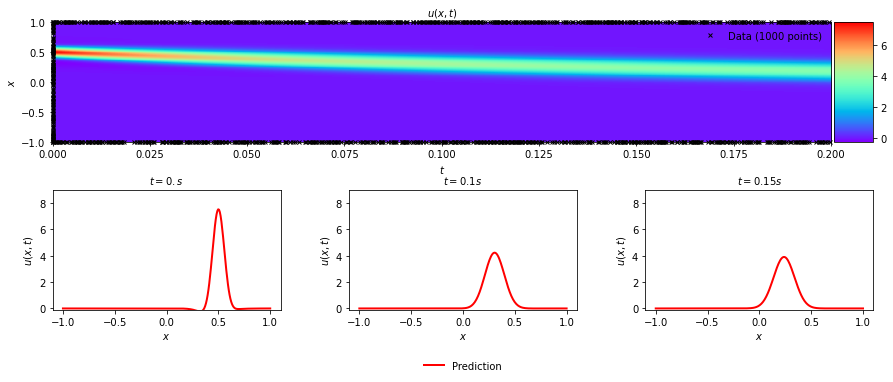

In [34]:
solutionplot(u_pred,X_u_train,u_train)

# Plot of collocation points

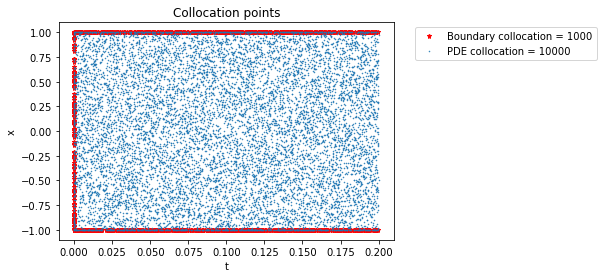

In [9]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [10]:
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

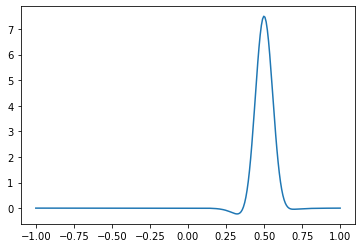

In [11]:
plt.plot(x, u_pred[:,1])

In [12]:
import ipywidgets

def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, T.max() - T.max()/1000, T.max()/100))

interactive(children=(FloatSlider(value=0.049, description='time', max=0.0999, step=0.001), Output()), _dom_cl…

<function __main__.inter_pred(time)>